In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro, BScores, GenomicBins
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores, exact_index
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.theory import bgs_segment, bgs_segment_sc16
from bgspy.classic import BSC16_segment_lazy

2022-08-16 10:07:28.582901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

TODO

 - nans in low rec causing issue?
 - Neh vs Ne

In [4]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


### bgspy B maps

In [5]:
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

bp = m.BpScores
b = m.BScores

In [6]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


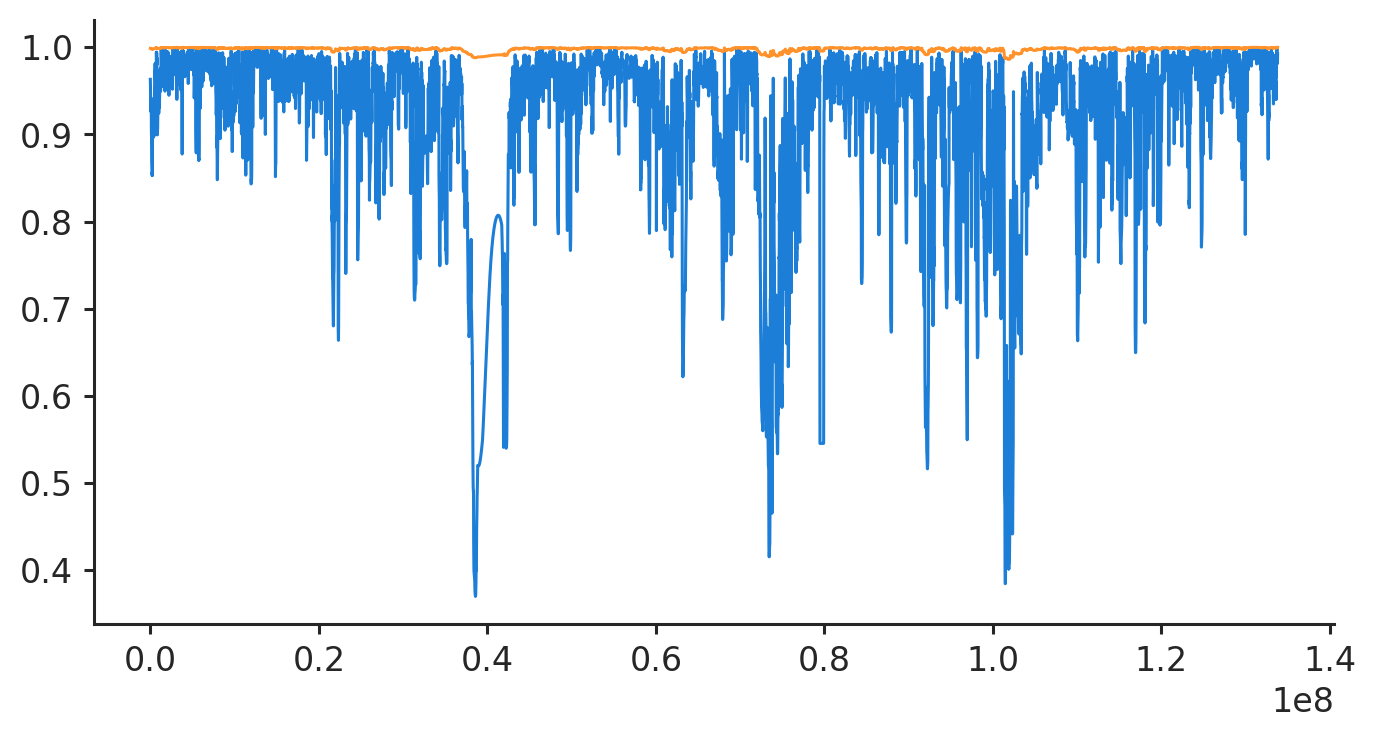

In [7]:
w = m.w[3]
t = m.t[0]
plt.plot(*b.pairs('chr10', w, t))
plt.plot(*bp.pairs('chr10', w, t))

## McVicker's `calc_bkgd` 

In [8]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_100000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)
mcvb.w, mcvb.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

## Simulation Data

In [9]:
sim_B = np.load('../data/slim_sims/chrombgs_chr10/chrombgs_chr10_thresh0/chrombgs_chr10_thresh0.npz', allow_pickle=True)
mus = sim_B['mu']
shs = sim_B['sh']

In [10]:
sim_B['X'].shape

(133798, 6, 7, 100)

Let's average a parameter set — lots of noise even with 100 reps:

In [11]:
mus, shs

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [12]:
sim_B['X'][:, 4, 4, 1]

array([1.2264819, 1.2264819, 1.2264819, ..., 0.744113 , 0.744113 ,
       0.744113 ], dtype=float32)

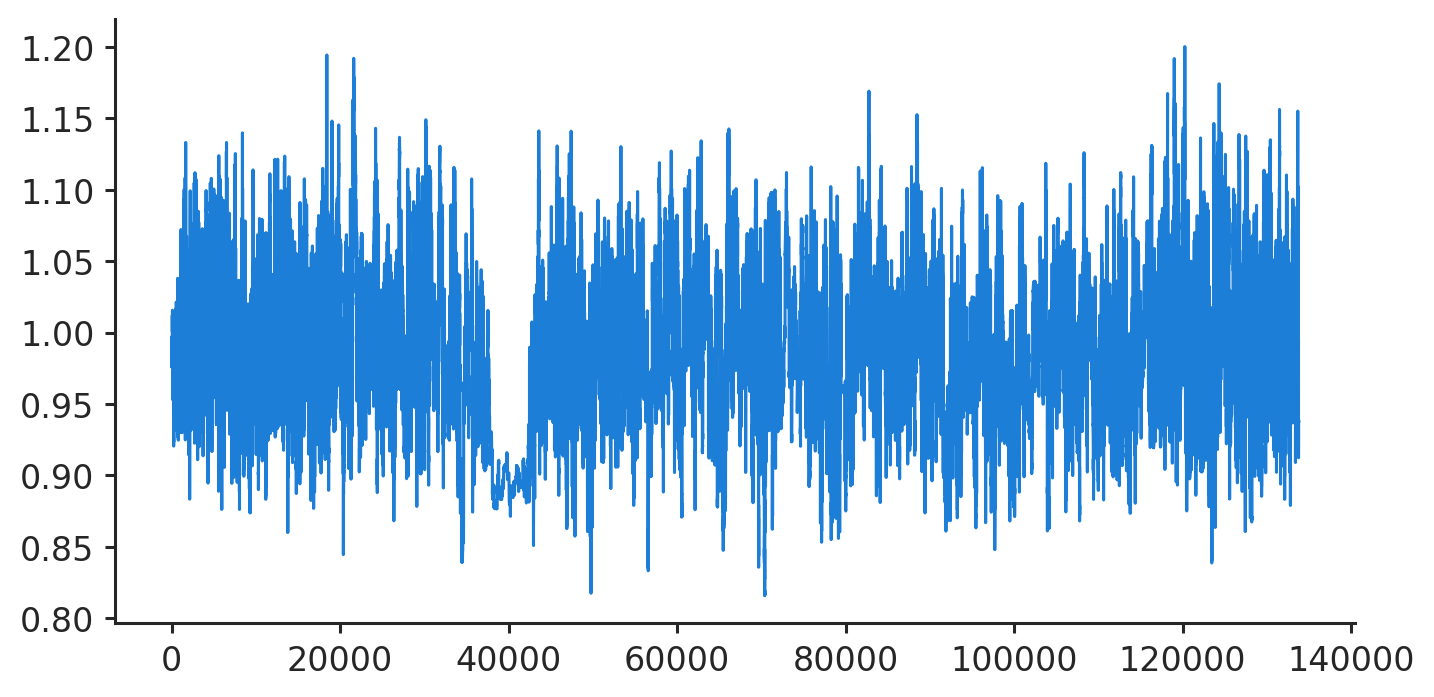

In [13]:
plt.plot(sim_B['X'].mean(axis=3)[:, 2, 5])

In [14]:
simb_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': simb_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': simb_pos}, mus, shs, step=None)

In [15]:
sim_means_500kb = sims_means.bin_means(GenomicBins(g.seqlens, 500_000))
sim_means_1Mb = sims_means.bin_means(GenomicBins(g.seqlens, 1_000_000))

sim_sd_500kb = sims_means.bin_means(GenomicBins(g.seqlens, 500_000))
sim_sd_1Mb = sims_means.bin_means(GenomicBins(g.seqlens, 1_000_000))


In [16]:
def comparison_plot(w, t, b, bp, sims, clcbg=None, sims_sds=None):
    x, y = sims['chr10', w, t]
    lines = plt.plot(x, y, label='sims')
    plt.plot(*b.pairs('chr10', w, t), label='B')
    plt.plot(*bp.pairs('chr10', w, t), label="B'", linestyle='dashed')
    if sims_sds is not None:
        x, sd = sims_sds['chr10', w, t]
        plt.fill_between(x, y - sd, y + sd, alpha=0.4, 
                         linewidth=0, color=lines[0].get_color())
    if clcbg is not None:
        plt.plot(*clcbg.pairs('chr10', w, t), label="calc_bkgd")
    plt.legend()
    plt.title(f"μ={w}, t={t}")

In [17]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

Let's look at a case that's approximately: high-ish mutation (1e-8 mutation, 10% of all SNPs are selected against with $s = 0.001$).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


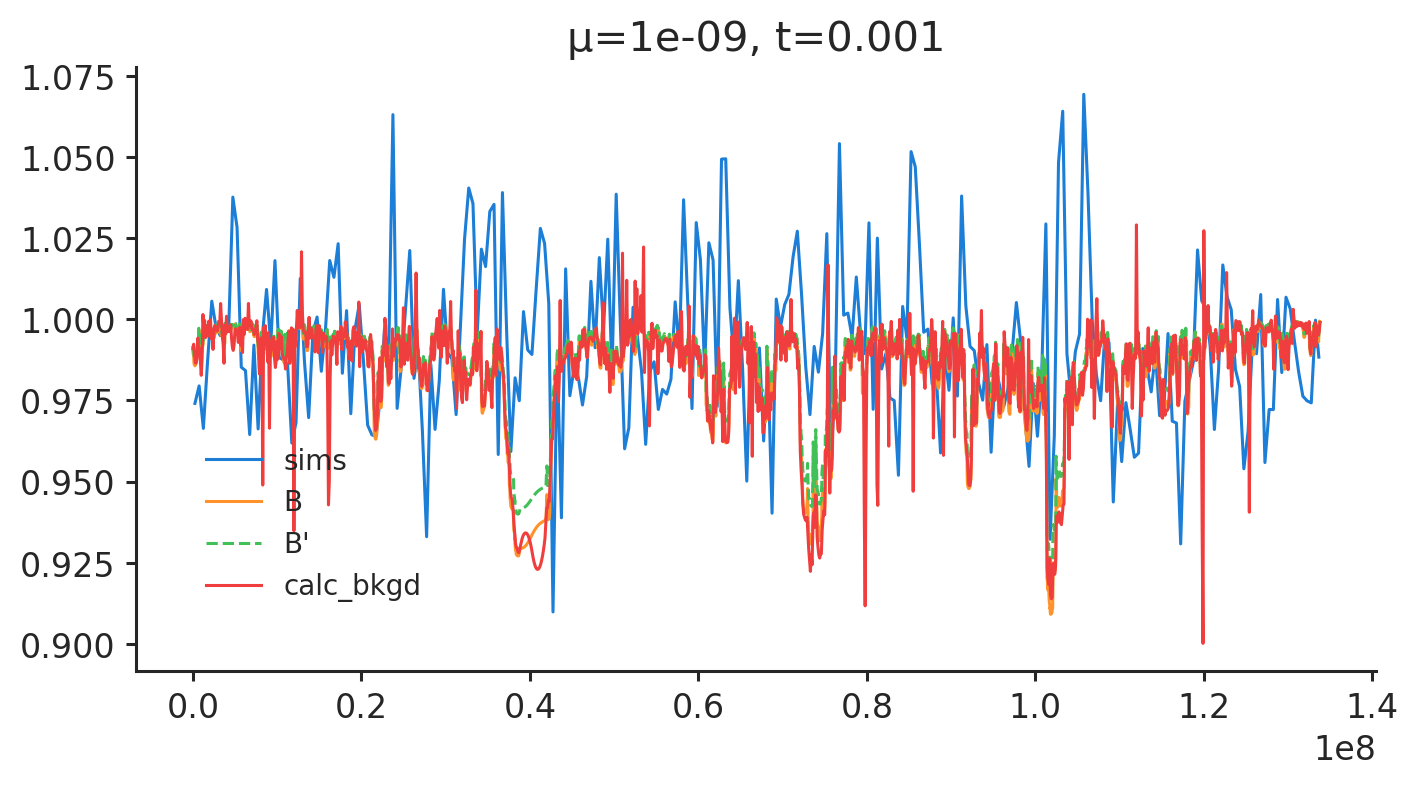

In [18]:
comparison_plot(1e-9, 0.001, b, bp, sims=sim_means_500kb, clcbg=mcvb)

Now, with even stronger selection:

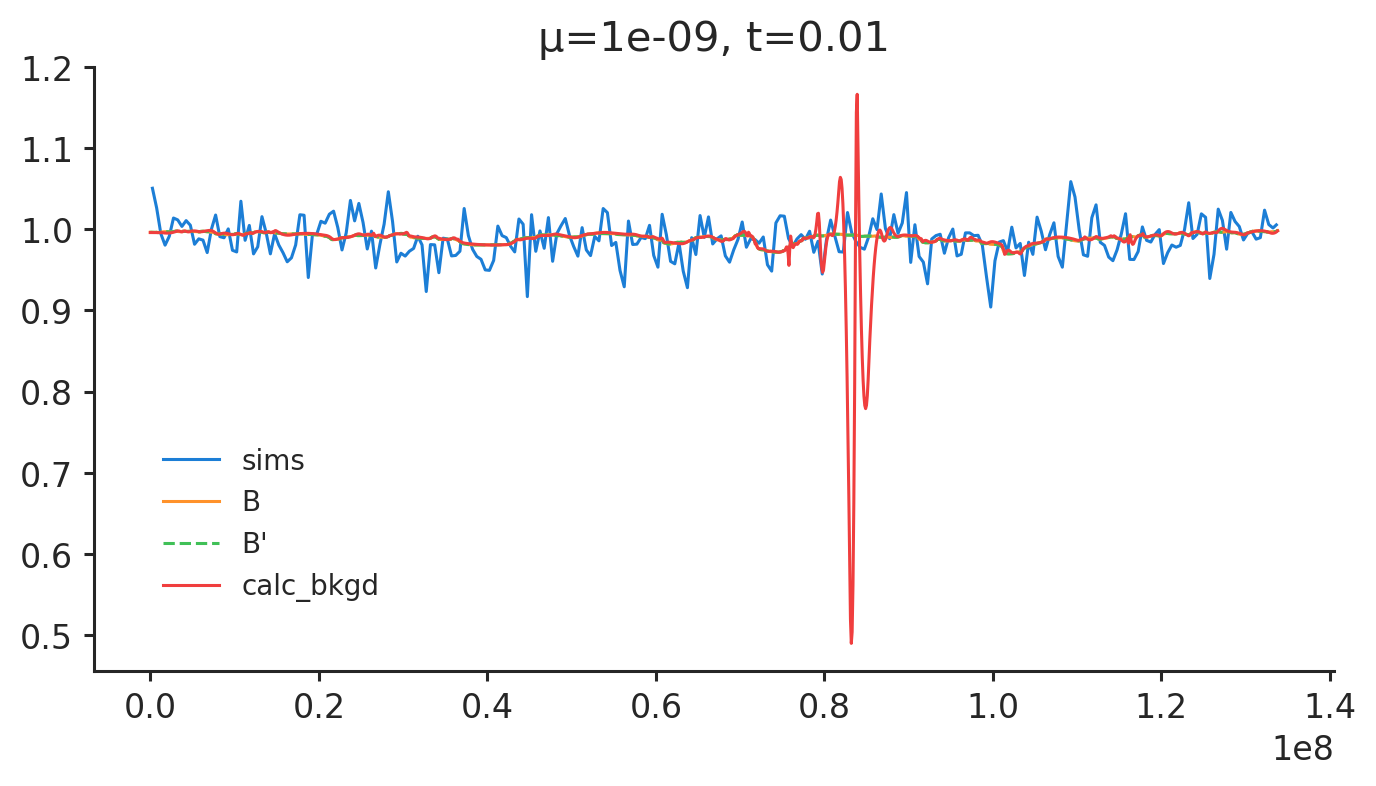

In [19]:
comparison_plot(m.w[2], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

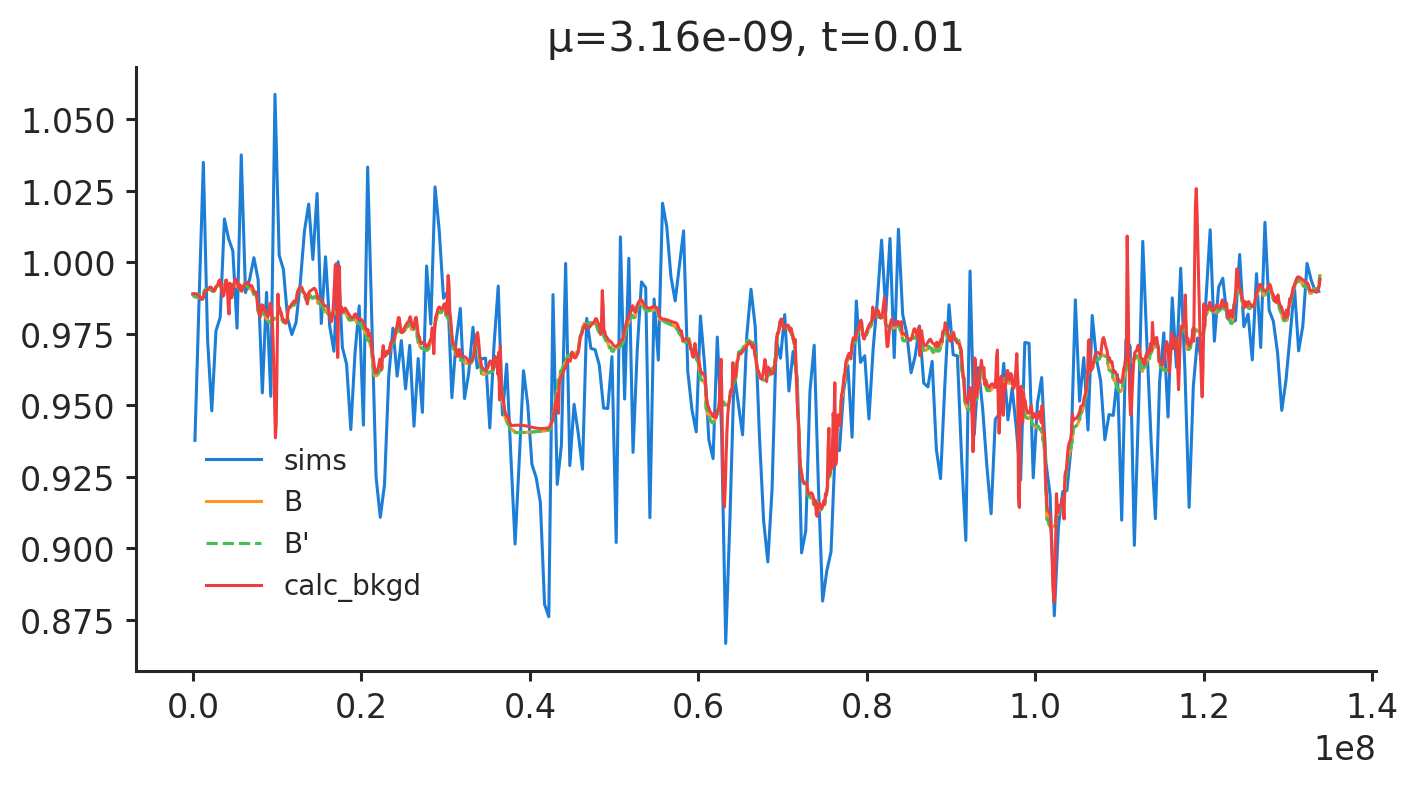

In [20]:
comparison_plot(m.w[3], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

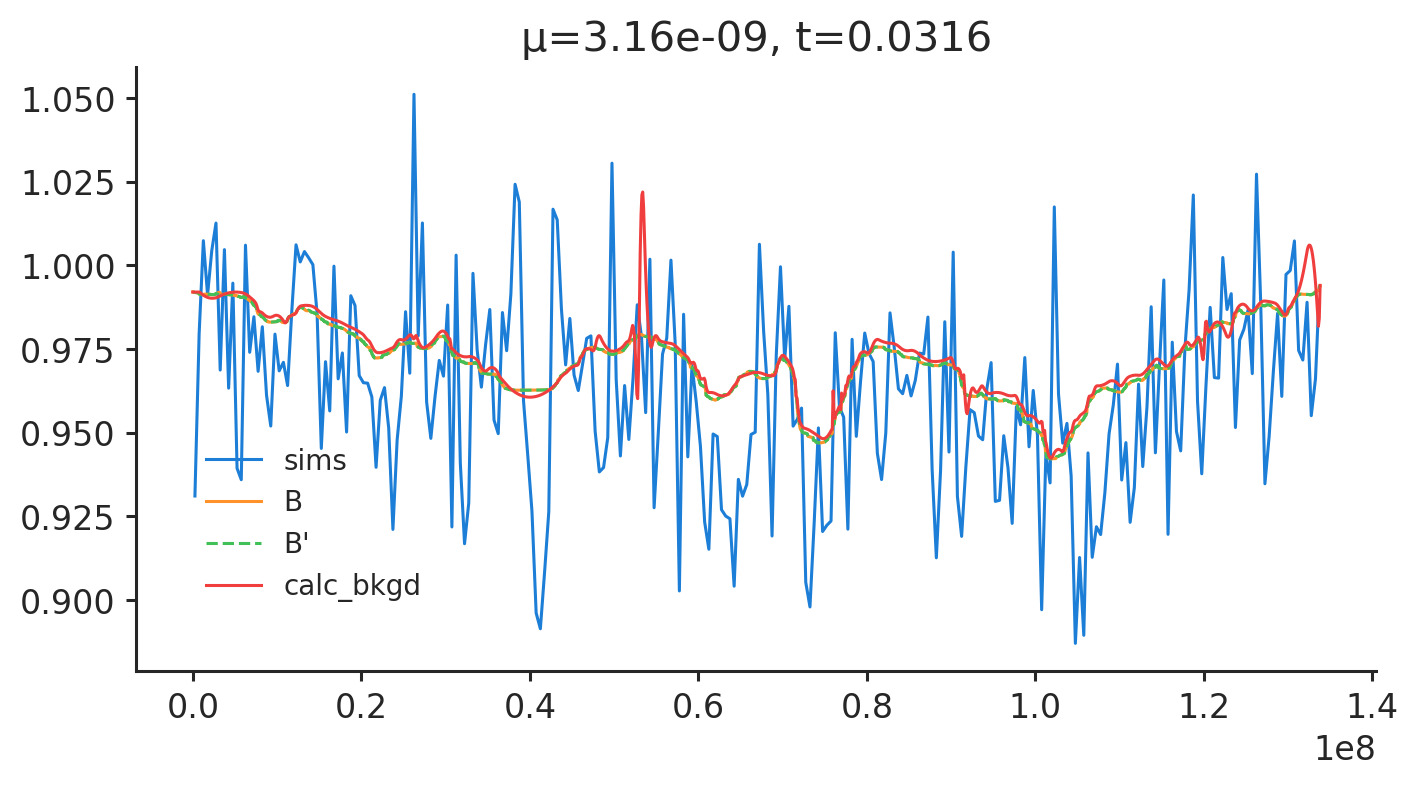

In [21]:
comparison_plot(m.w[3], m.t[5],  b, bp, sims=sim_means_500kb, clcbg=mcvb)

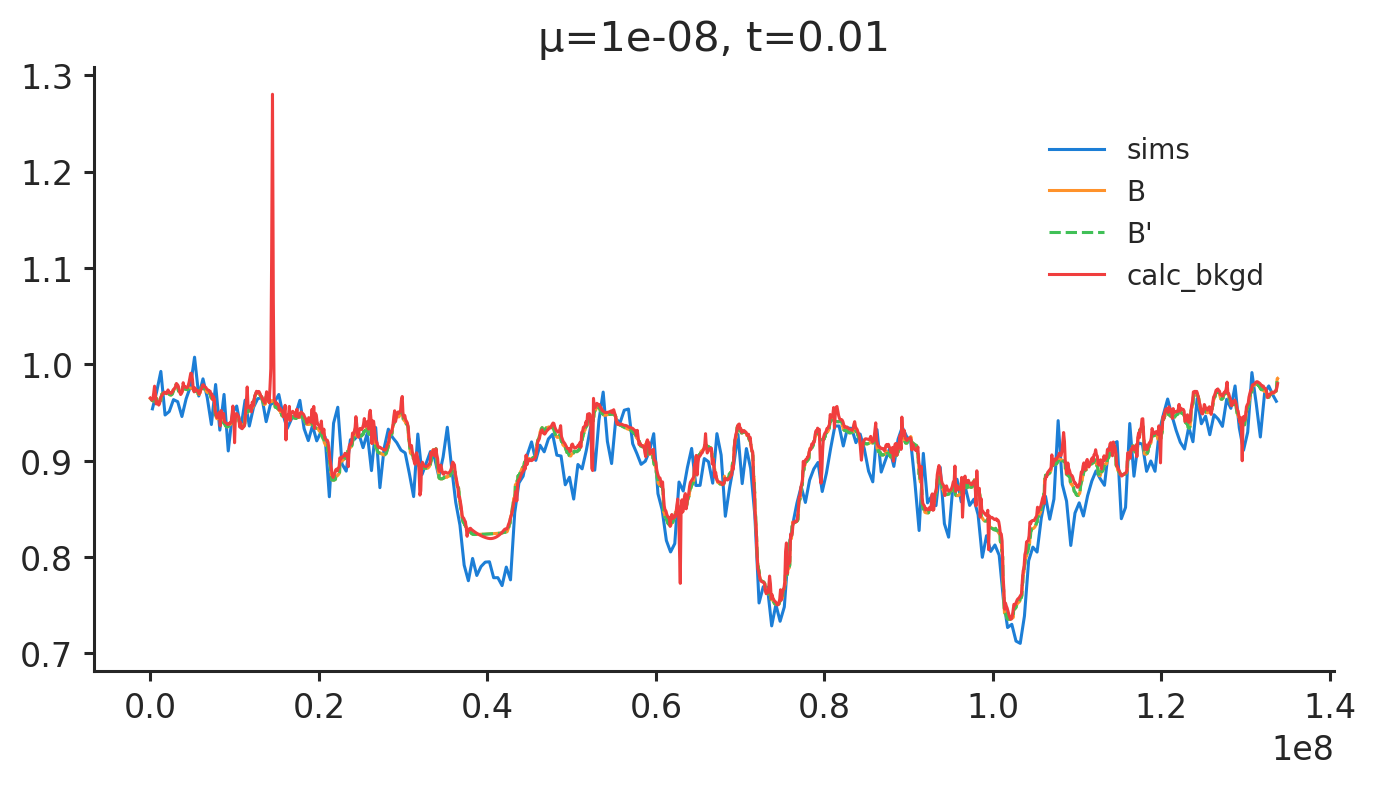

In [22]:
comparison_plot(m.w[4], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

(0.7, 1.1)

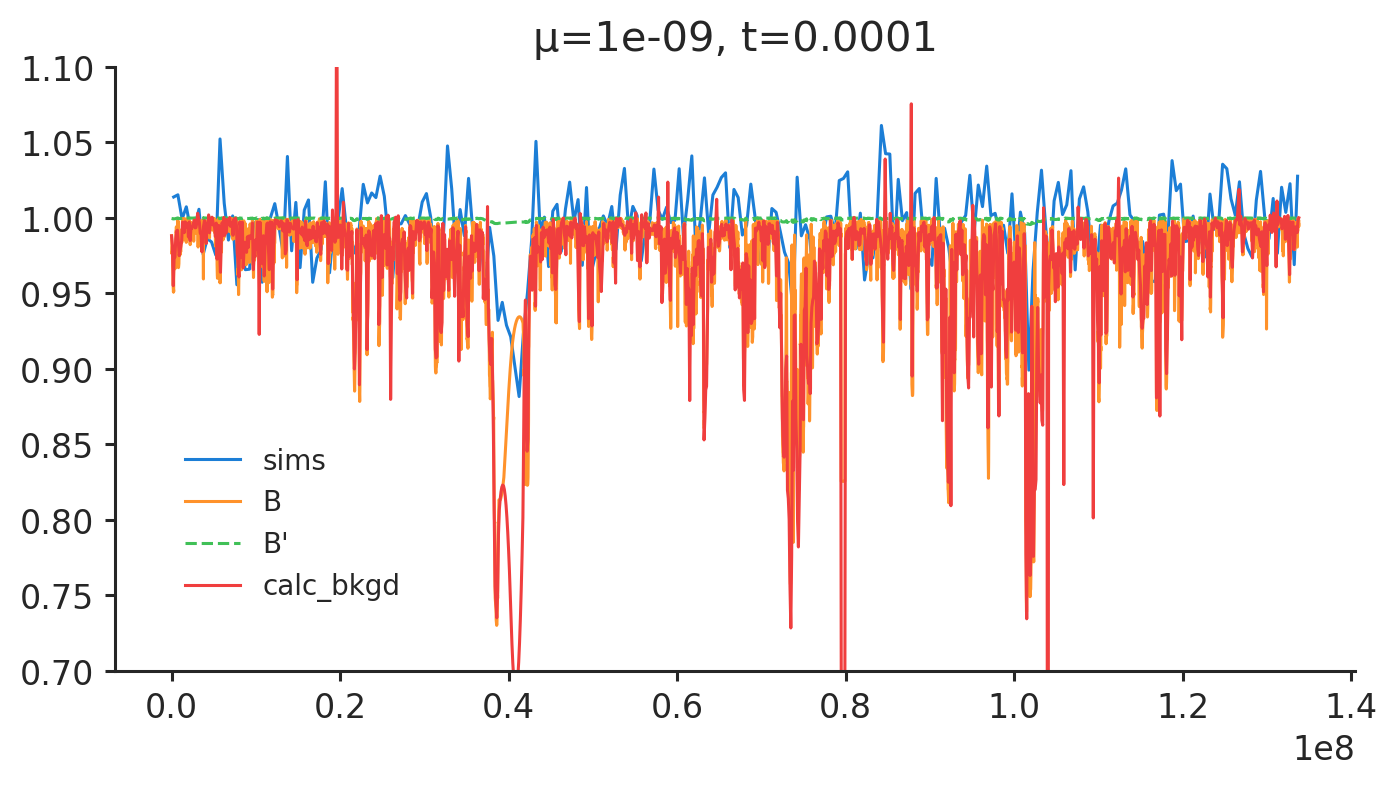

In [23]:
comparison_plot(1e-9, 0.0001, b, bp, sims=sim_means_500kb, clcbg=mcvb)
plt.ylim(0.7, 1.1)

## Simulations

building interpolators...		done.
building interpolators...		done.


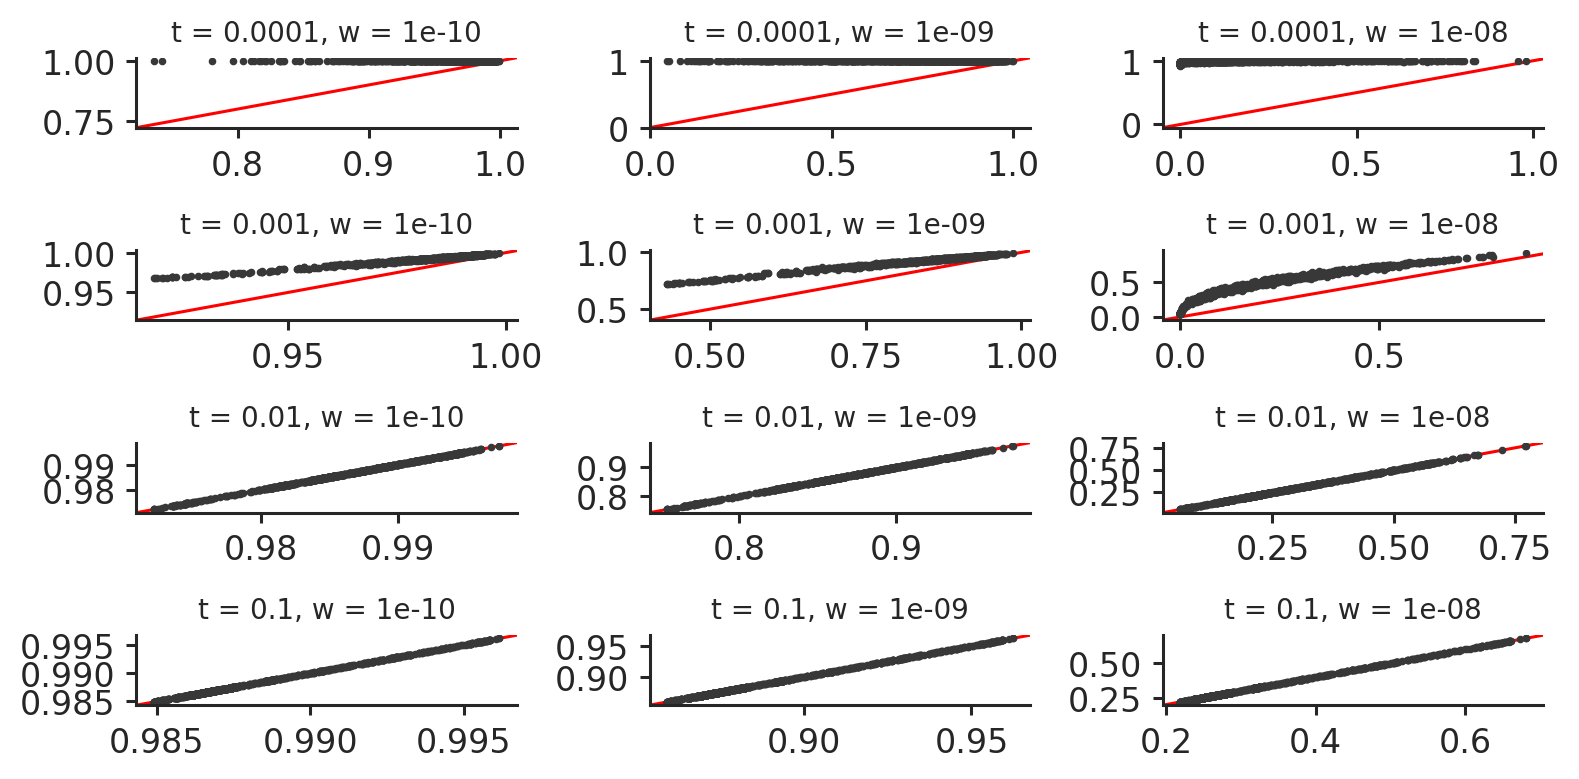

In [26]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sim_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


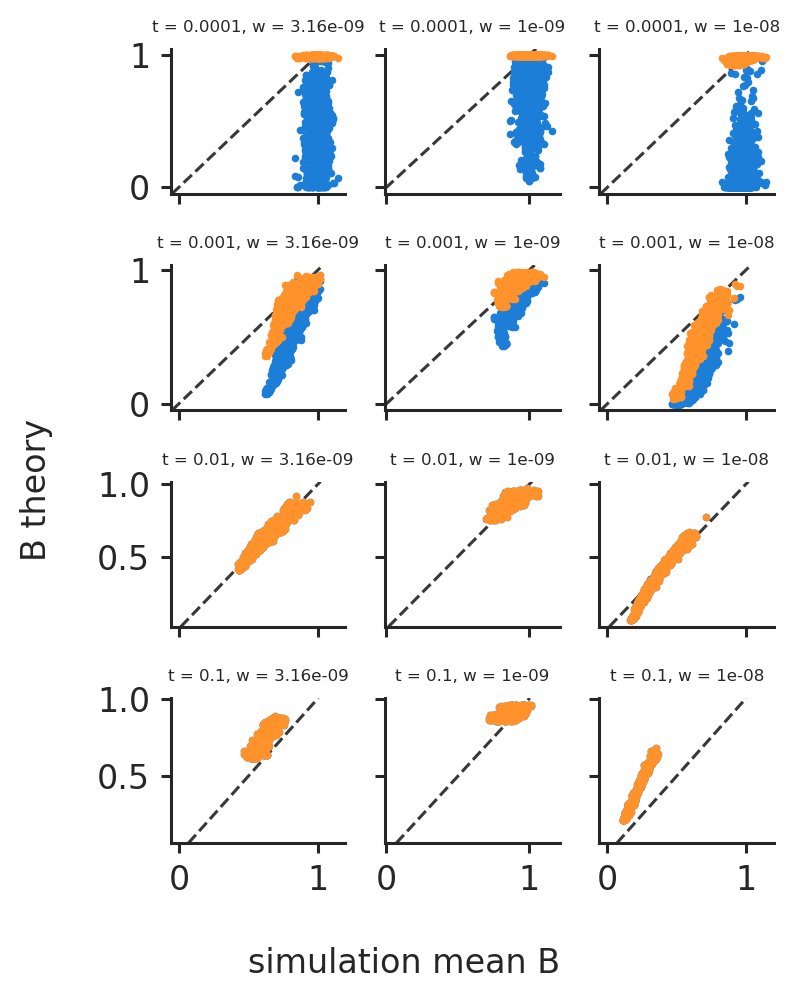

In [30]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, y, s=3)
    ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

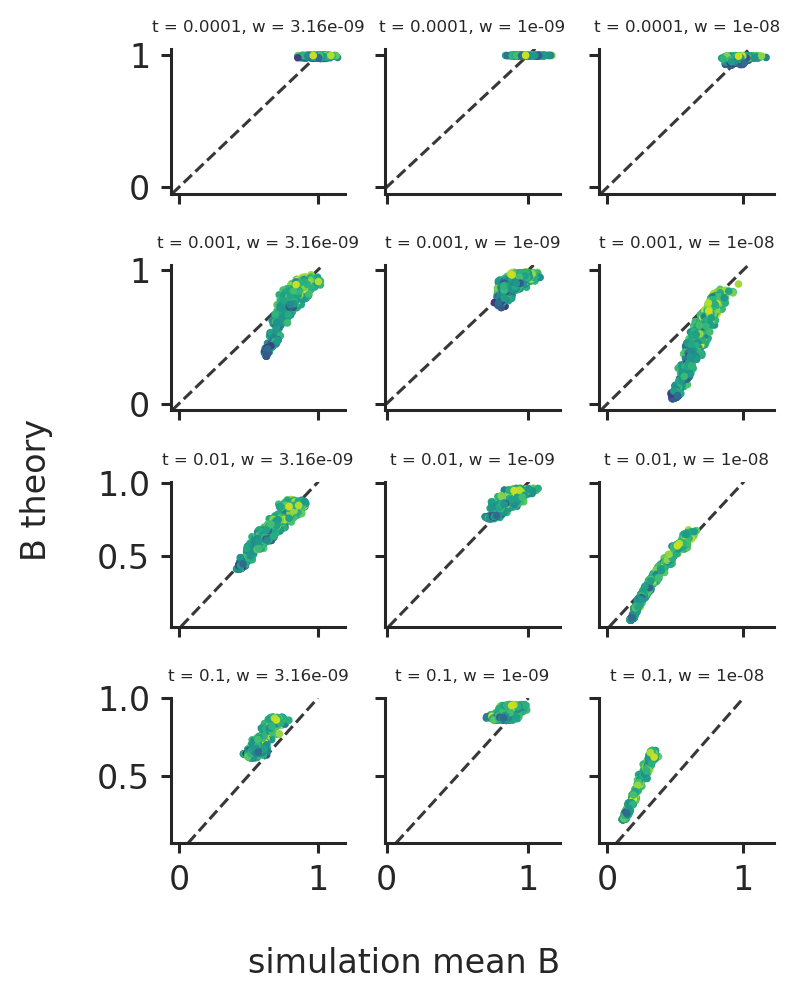

In [66]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

all_sim, all_bsc = [], []
all_s, all_mu = [], []
all_pos = []

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, ya, s=3, c=g.recmap.lookup('chr10', pos), norm=mpl.colors.LogNorm())
    all_s.extend([sh]*len(x))
    all_mu.extend([mu]*len(x))
    all_sim.extend(x.tolist())
    all_pos.extend(pos.tolist())
    all_bsc.extend(ya.tolist())
    #ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

In [153]:
from bgspy.utils import load_bed_ranges
from bgspy.plots import surface_plot, chrom_plot

In [266]:
f = "../data/chrombgs_chr10_N1000_mu1e-08_sh0.001_chr10_seed1001729303_rep17_dac.tsv.gz"

m.load_dacfile(f, load_bed_ranges('../data/annotation/neutral_chr10.bed'))

0 sites in non-neutral regions skipped.


In [263]:
m.Y

{'chr10': array([[1020025.,  978975.],
        [1969225.,   29775.],
        [1937961.,   61039.],
        ...,
        [1762876.,  236124.],
        [1997001.,    1999.],
        [1993009.,    5991.]])}

In [265]:
b.pos

defaultdict(list,
            {'chr10': array([        0,      1000,      2000, ..., 133796000, 133797000,
                    133797421], dtype=uint32)})

In [165]:
pi0 = 4*1000*1.5e-8
pi0

5.9999999999999995e-05

In [273]:
llc, pi0c = m.loglikelihood(1e6, pi0=4*1000*1.5e-8, method='classic')

building interpolators...		done.
> /home/vsb/projects/bprime/bgspy/likelihood.py(135)calc_loglik_components()
    133             Y_binned[chrom] = np.stack((ndiff + nsame_fixed, ndiff)).T
    134             __import__('pdb').set_trace()
--> 135             pi_win[chrom] = ndiff / (ndiff + nsame_fixed)
    136     return Y_binned, win_Bs, pi_win
    137 



ipdb>  Y_binned[chrom].shape


(134, 2)


ipdb>  exit


BdbQuit: 

In [271]:
debug

> /home/vsb/projects/bprime/bgspy/likelihood.py(54)loglik()
     52     nD = y[:, 1, None, None]
     53     nS = y[:, 0, None, None]
---> 54     a = np.log(pi)*nD
     55     b = np.log1p(-pi)*nS
     56     assert(np.all(np.isfinite(a) | np.isnan(a)))



ipdb>  pi.shape


(6, 7, 134)


ipdb>  nD.shape


(134, 1, 1)


ipdb>  nD


array([[[23536159.]],

       [[23935633.]],

       [[28338204.]],

       [[23097498.]],

       [[26159183.]],

       [[24718074.]],

       [[19353414.]],

       [[11820085.]],

       [[11258056.]],

       [[15295632.]],

       [[20364588.]],

       [[13506120.]],

       [[12922906.]],

       [[17294489.]],

       [[18644306.]],

       [[16923844.]],

       [[14541812.]],

       [[10395853.]],

       [[13062211.]],

       [[12576100.]],

       [[18541760.]],

       [[10720522.]],

       [[ 9074880.]],

       [[18123015.]],

       [[ 9678242.]],

       [[20932259.]],

       [[15867569.]],

       [[14393297.]],

       [[19603373.]],

       [[25408183.]],

       [[17018370.]],

       [[20802331.]],

       [[31890768.]],

       [[21077579.]],

       [[17162286.]],

       [[10910698.]],

       [[21751603.]],

       [[16089935.]],

       [[18992379.]],

       [[33015664.]],

       [[33056767.]],

       [[32671047.]],

       [[25345020.]],

       [[20

ipdb>  exit


In [80]:
ll, pi0 = m.loglikelihood(pi0=4*1000*1.5e-8)

In [151]:
np.sum(ll, axis=0).shape, m.w.shape, m.t.shape

((6, 7), (6,), (7,))

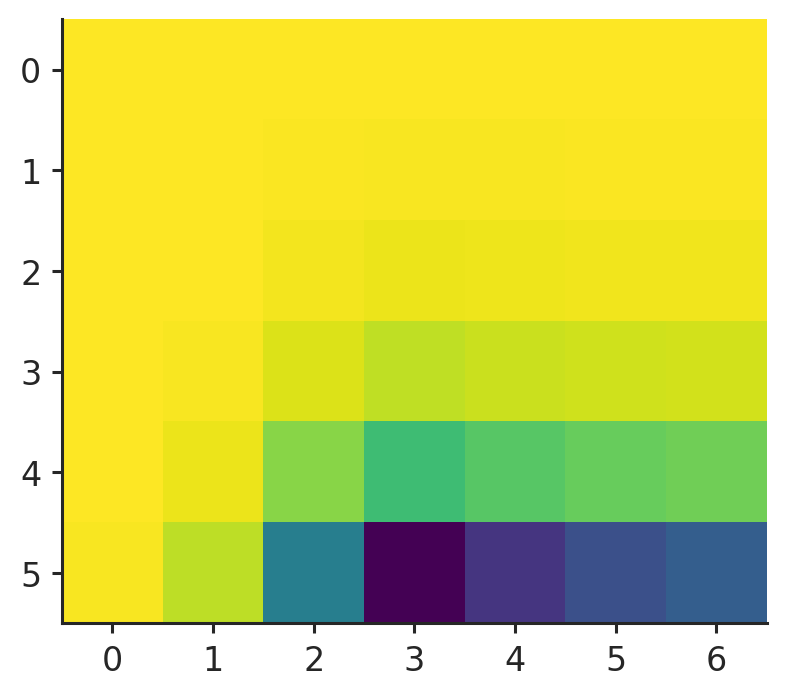

In [152]:
plt.imshow(np.sum(ll, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

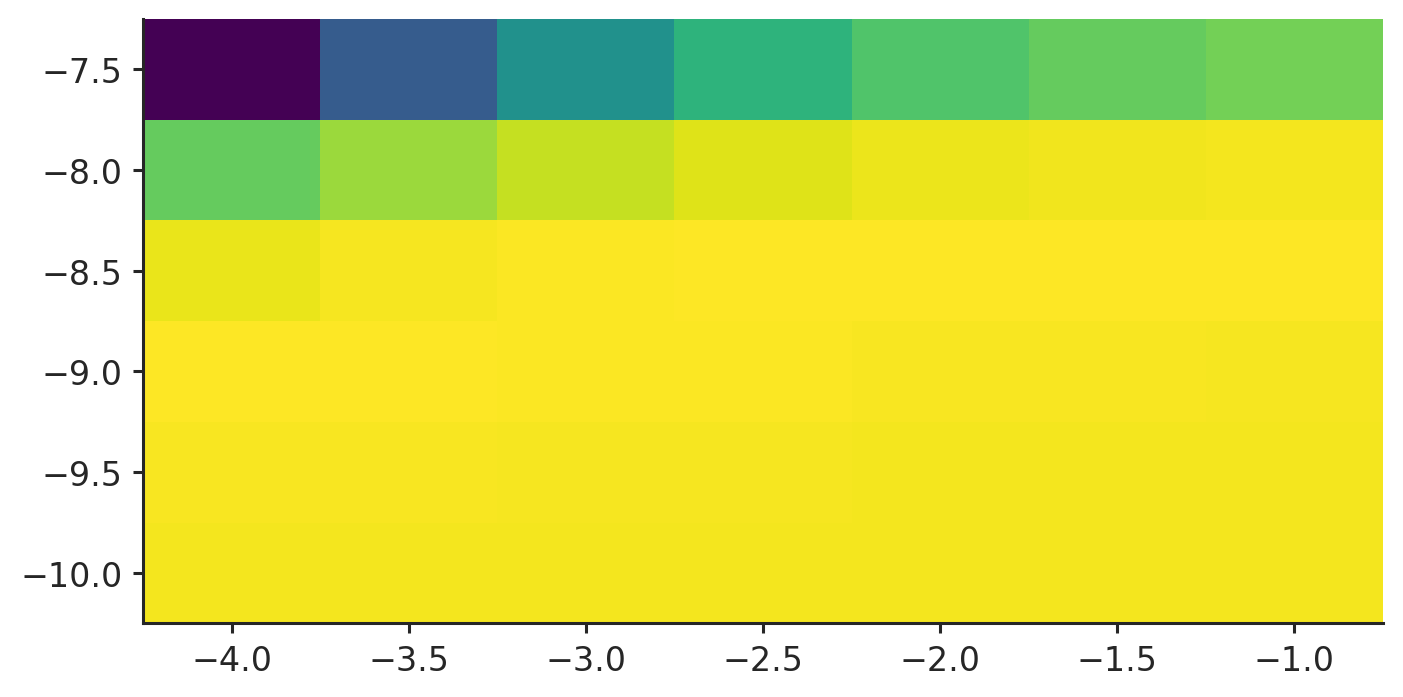

In [111]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(llc, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

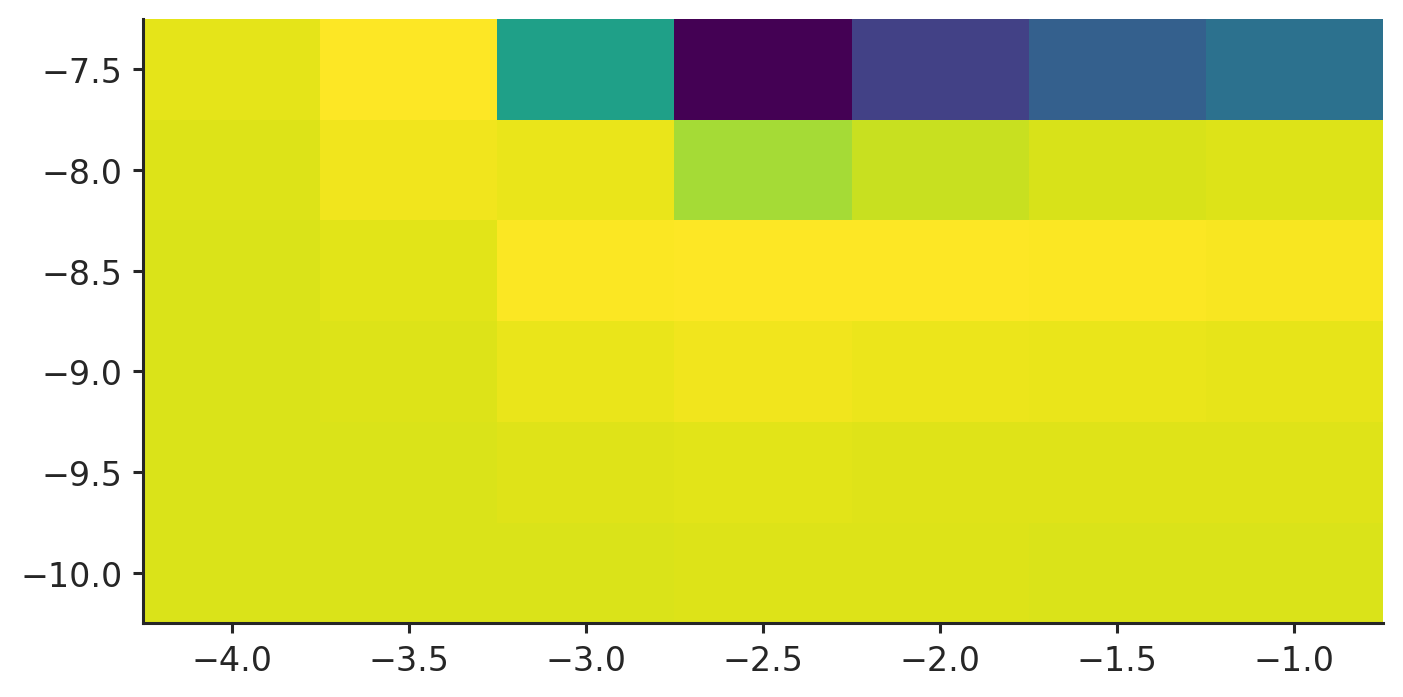

In [102]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(ll, axis=0))

In [209]:
f2 = '../data/chrombgs_chr10_N1000_mu3.16e-09_sh0.0001_chr10_seed1107950420_rep23_dac.tsv.gz'
m.load_dacfile(f2, load_bed_ranges('../data/annotation/neutral_chr10.bed'))

0 sites in non-neutral regions skipped.


In [190]:
pi0_grid = np.logspace(-5, -3, 20)

In [215]:
llc, pi0c = m.loglikelihood(pi0_grid=pi0_grid, method='classic')
ll, pi0 = m.loglikelihood(pi0_grid=pi0_grid)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.30it/s]


(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

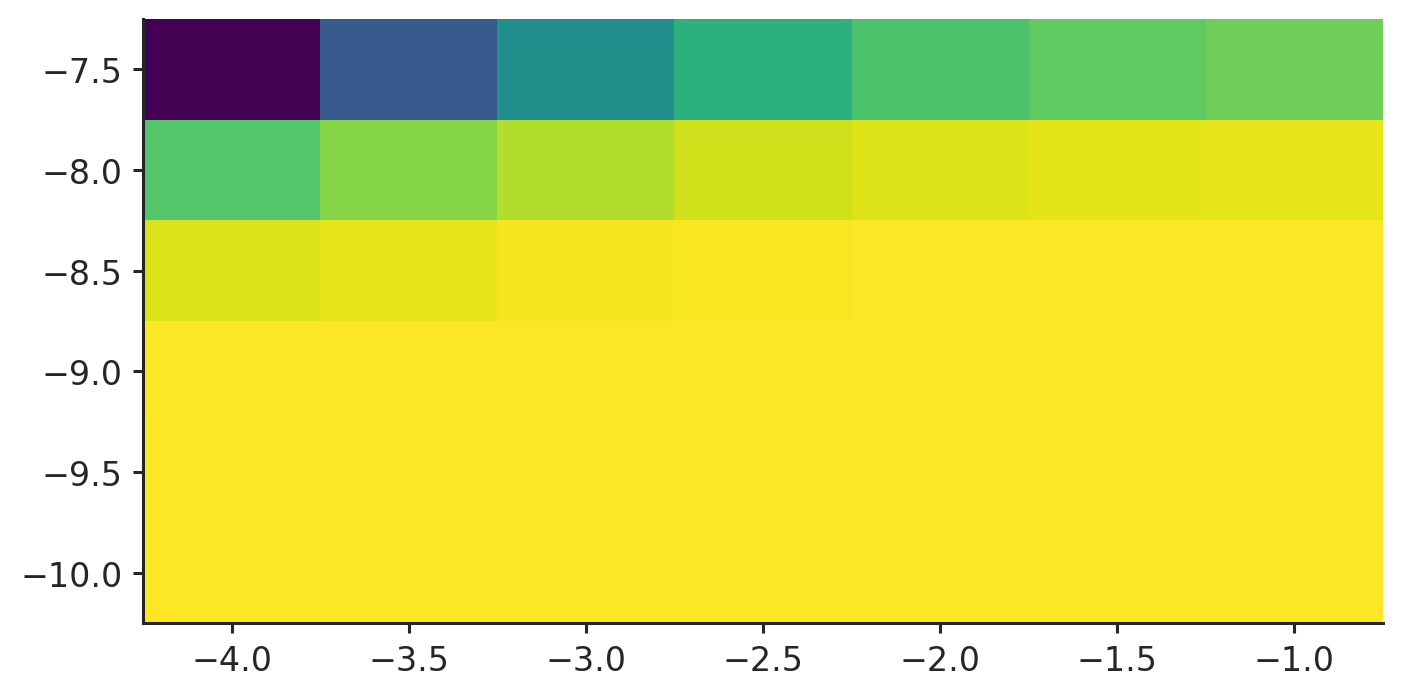

In [216]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(llc, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

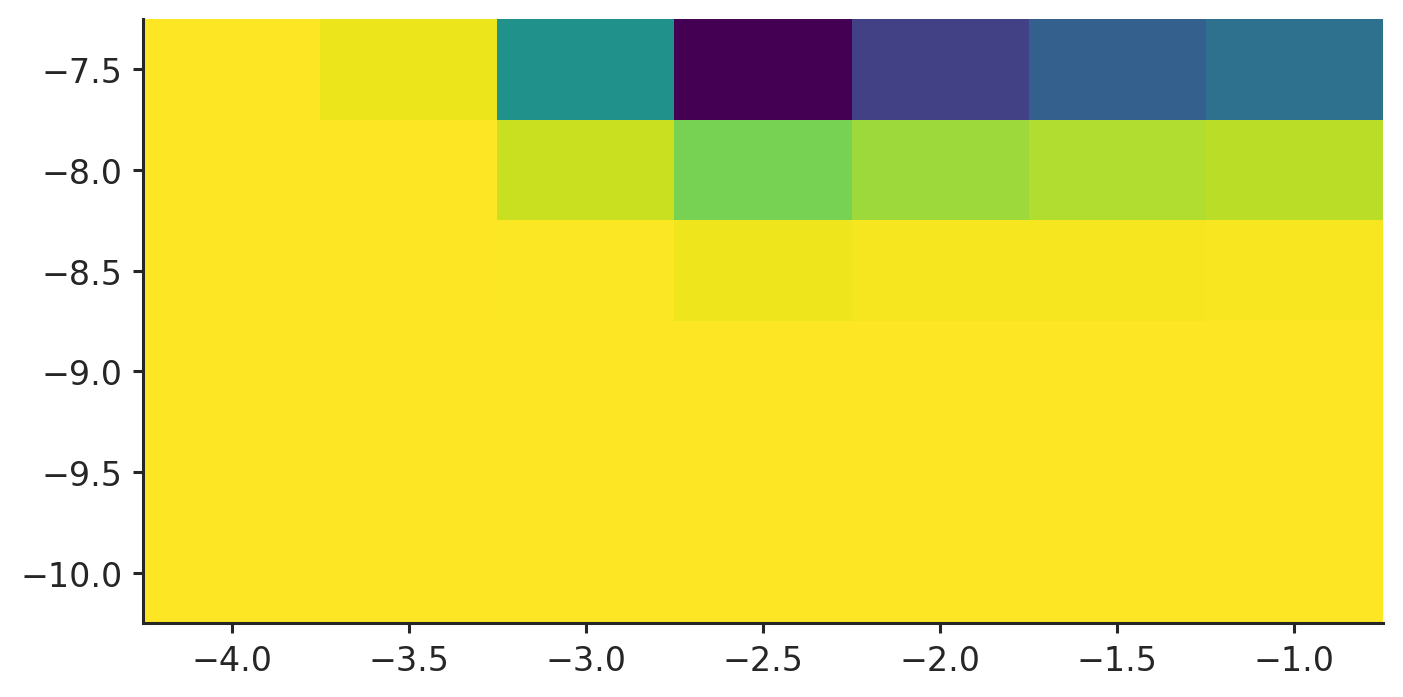

In [217]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(ll, axis=0))

In [218]:
pi0, pi0c

(0.0006158482110660261, 0.0006158482110660261)

In [219]:
from bgspy.utils import bin_chrom
import tskit
ts = tskit.load('../data/chrombgs_chr10_N1000_mu3.16e-09_sh0.0001_chr10_seed1107950420_rep23_treeseq.tree')

In [231]:
bins = bin_chrom(ts.sequence_length+1, 1_000_000)
#ts.diversity(windows=bins, mode='branch')

In [232]:
ts.diversity()

array(8.64303173e-06)

In [256]:
np.where(ll.sum(axis=0) == np.min(ll.sum(axis=0)))

(array([5]), array([3]))

In [257]:
len(list(ts.mutations()))

11372

[3.16e-09] [0.0316]


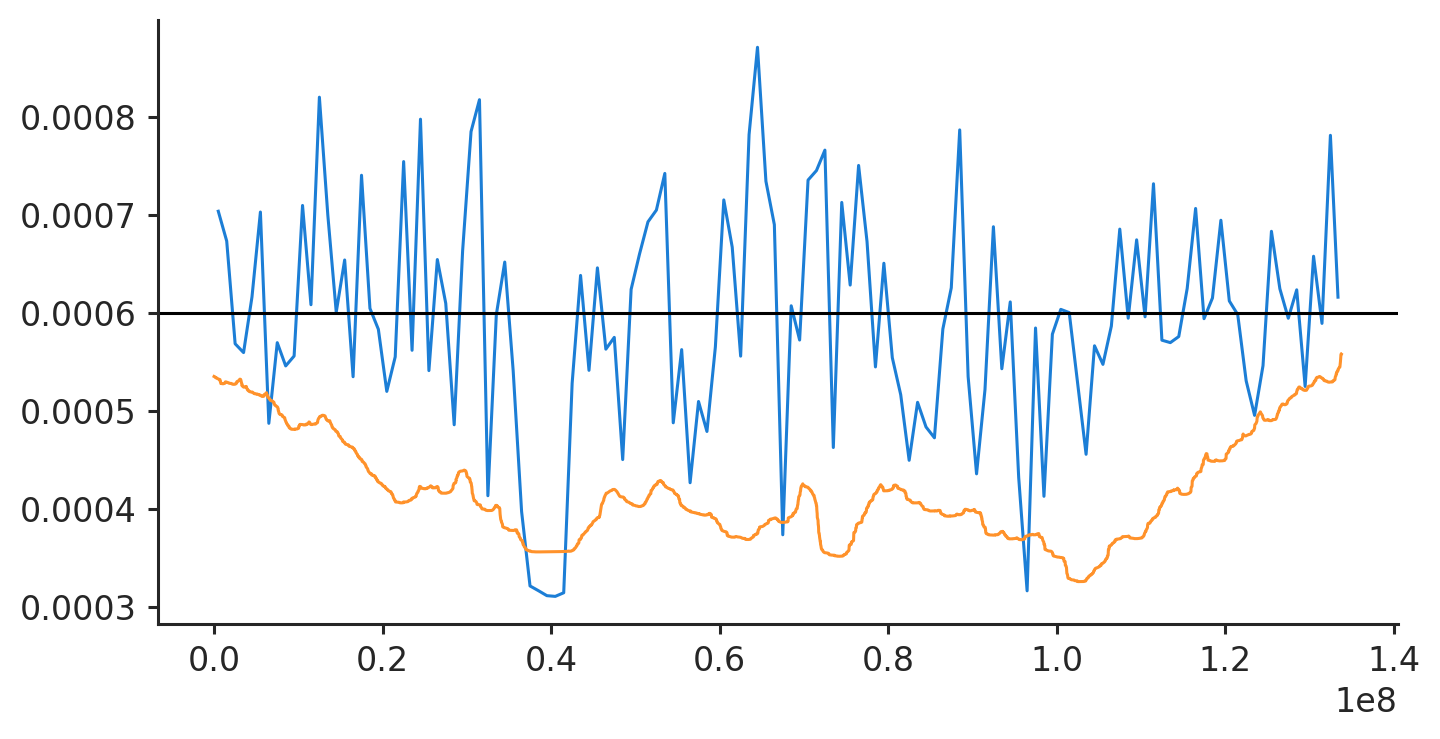

In [260]:
wi, ti = np.where(ll.sum(axis=0) == np.min(ll.sum(axis=0)))

mu = m.w[ti]
sh = m.t[wi]
print(mu, sh)
x, y = bp['chr10', mu, sh]

nmu = 1.5e-7
N = 1000

plt.plot(0.5*(bins[1:] + bins[:-1]), nmu*ts.diversity(windows=bins, mode='branch'))
#plt.plot(x, y * pi0)
#x, y = sims_means['chr10', mu, sh]
plt.plot(x, y*pi0)
plt.axhline(4*N*nmu, c='k')

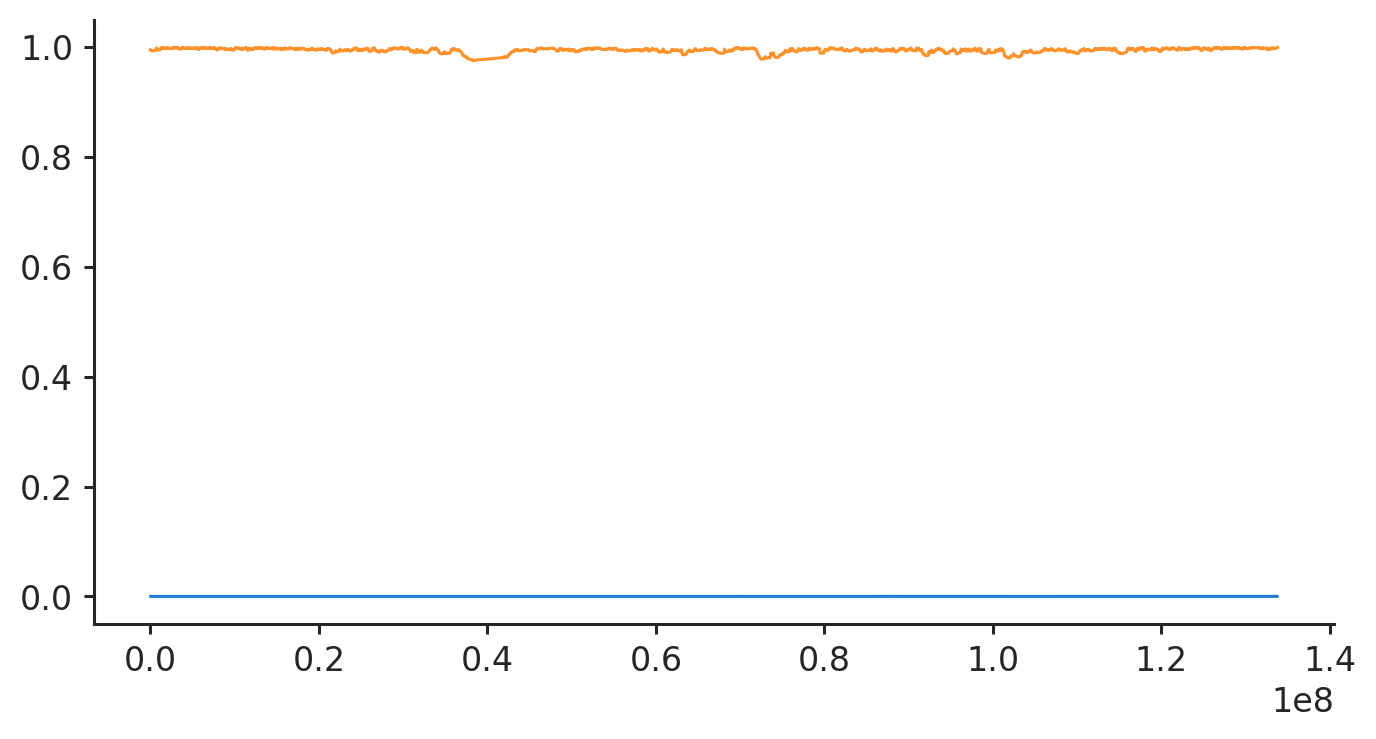

In [225]:
mu = m.w[3]
sh = m.t[0]
x, y = bp['chr10', mu, sh]

plt.plot(0.5*(bins[1:] + bins[:-1]), ts.diversity(windows=bins))
plt.plot(x, y)

In [188]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [170]:
ts.diversity()

array(8.64303173e-06)

In [155]:
chrom_plot(m.loglikelihood(pi0=pi0), 'chr10')

ValueError: not enough values to unpack (expected 15, got 2)